In [1]:
# Data Preparation & Cleaning
import pandas as pd

df= pd.read_csv("BCR - Real Estate Data.csv", delimiter=";")

df.head()


,District,Area (in m^2),Price (in AZN),Price per m^2,Rooms,Floor,Total floors
0,Absheron,133,235809,1773,5,6,20
1,Narimanov,62,186744,3012,3,1,13
2,Khatai,38,92910,2445,2,2,11
3,Abseron,72,143640,1995,3,15,19
4,Yasamal,147,448497,3051,1,1,15


In [2]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   District        200 non-null    object
 1   Area (in m^2)   196 non-null    object
 2   Price (in AZN)  196 non-null    object
 3   Price per m^2   195 non-null    object
 4   Rooms           200 non-null    object
 5   Floor           200 non-null    object
 6   Total floors    200 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 11.1+ KB


In [3]:
df.isnull().sum()

District          0
Area (in m^2)     4
Price (in AZN)    4
Price per m^2     5
Rooms             0
Floor             0
Total floors      0
dtype: int64

In [4]:
# Price and Area empty rows
missing_price_area = df[df["Price (in AZN)"].isnull() | df["Area (in m^2)"].isnull()]
missing_price_area


,District,Area (in m^2),Price (in AZN),Price per m^2,Rooms,Floor,Total floors
5,Khatai,NaN,186263,2419,2,11,17
12,Yasamal,NaN,207533,2627,1,11,19
22,Nasimi,NaN,356730,3795,5,7,20
59,Narimanov,NaN,195533,2197,3,10,7
133,Yasamal,123,NaN,2400,1,3,11
167,Yasamal,53,NaN,3069,4,9,9
179,Narimanov,64,NaN,2992,1,9,8
197,Nasimi,124,NaN,2789,5,4,6


In [5]:
# Price and Area empty rows cleaned
df = df.dropna(subset=["Price (in AZN)", "Area (in m^2)"])  
df.isnull().sum()

District          0
Area (in m^2)     0
Price (in AZN)    0
Price per m^2     5
Rooms             0
Floor             0
Total floors      0
dtype: int64

In [6]:
# Automatically convert all columns to numeric except 'District'
df = df.apply(lambda col: pd.to_numeric(col.astype(str).str.replace(r"[^0-9.]", "", regex=True), 
                                        errors="coerce")
              if col.name != "District" else col).copy()

# # Price and Area columns to integer
# df["Price (in AZN)"] = df["Price (in AZN)"].astype(int)
# df["Area (in m^2)"] = df["Area (in m^2)"].astype(int)

df.dtypes

# Rooms column empty values filled with median
median_rooms = int(round(df["Rooms"].median()))
df.loc[:, "Rooms"] = df["Rooms"].fillna(median_rooms).round().astype("Int64")

In [7]:
from fuzzywuzzy import process, fuzz
import re
df["District"].value_counts()

correct_districts = ['Absheron', 'Narimanov', 'Khatai', 'Nasimi', 'Yasamal', 'Binagadi', 'Sabail']

df['District_std'] = df['District'].apply(lambda x: process.extractOne(
    re.sub(r'[^a-zA-Z]', '', str(x)).title(),
    correct_districts, scorer=fuzz.ratio)[0]
    if pd.notna(x) else x)

# The above code standardizes district names:
# First, it removes all non-letter characters from the District column values.
# Then, it uses fuzzy matching to replace them with the closest correct district name from the list.

df[['District', 'District_std']].value_counts()

df = df.drop(columns=['District']).rename(columns={'District_std': 'District'})

df['District'].value_counts()

C:\Users\User\AppData\Roaming\Python\Python313\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


District
Absheron     37
Narimanov    32
Khatai       28
Nasimi       25
Sabail       24
Yasamal      23
Binagadi     23
Name: count, dtype: int64

In [ ]:
import numpy as np
from scipy import stats

# Safely recalculate Price per m^2
df.loc[df["Area (in m^2)"] == 0, "Price per m^2"] = np.nan
df["Price per m^2"] = df["Price (in AZN)"] / df["Area (in m^2)"]

# ==== Outlier detection ====

# --- IQR method ---
q1 = df["Price per m^2"].quantile(0.25)
q3 = df["Price per m^2"].quantile(0.75)
iqr = q3 - q1
lb = q1 - 1.5 * iqr
ub = q3 + 1.5 * iqr

df["Outlier_IQR"] = (df["Price per m^2"] < lb) | (df["Price per m^2"] > ub)

# --- Z-score method (|z| > 3) ---
z_vals = pd.Series(
    stats.zscore(df["Price per m^2"], nan_policy="omit"),
    index=df.index
)
df["Outlier_Z"] = z_vals.abs() > 3

# Combined decision columns
df["Outlier_EITHER"] = df["Outlier_IQR"] | df["Outlier_Z"]  # union
df["Outlier_BOTH"]   = df["Outlier_IQR"] & df["Outlier_Z"]  # intersection

print({
    "count": int(df["Price per m^2"].notna().sum()),
    "iqr_outliers": int(df["Outlier_IQR"].sum()),
    "z_outliers": int(df["Outlier_Z"].sum()),
    "either_method": int(df["Outlier_EITHER"].sum()),
    "both_method": int(df["Outlier_BOTH"].sum())
})

# Count
df["Outlier_EITHER"].value_counts()
df["Outlier_BOTH"].value_counts()

df.head()

# Cleaning
df_clean = df.loc[~df["Outlier_EITHER"]].copy()
df_clean.reset_index(drop=True, inplace=True)


{'count': 192, 'iqr_outliers': 8, 'z_outliers': 0, 'either_method': 8, 'both_method': 0}


District
Absheron     37
Narimanov    32
Khatai       28
Nasimi       25
Sabail       24
Yasamal      23
Binagadi     23
Name: count, dtype: int64

In [11]:
# Descriptive Statistics
# •	Price, Area, Price/m² üçün: mean, median, min, max, std.
stats_tbl = (
    df_clean[["Price (in AZN)","Area (in m^2)","Price per m^2"]]
    .agg(["count","mean","median","min","max","std"])
    .T.round(2)
)
stats_tbl

# •	Rooms distribution: most common 1-2-3 room apartments share.

rooms_s  = pd.to_numeric(df_clean["Rooms"], errors="coerce").round().astype("Int64")
rooms_cnt = rooms_s.value_counts().sort_index()
rooms_pct = (rooms_cnt / rooms_cnt.sum() * 100).round(1)

r123 = rooms_pct.reindex([1,2,3]).fillna(0)
r4p  = round(100 - r123.sum(), 1)
print(f"Rooms share: 1 room %{r123.get(1,0)}, 2 room %{r123.get(2,0)}, 3 room %{r123.get(3,0)}, 4+ room %{r4p}")

# District shares (single column)
district_cnt = df_clean["District"].value_counts().sort_values(ascending=False)
district_pct = (district_cnt / district_cnt.sum() * 100).round(1)
print("Most common 5 districts:", district_pct.head(5).to_dict())



# Using the IQR method, ≈4% (8/192) of Price per m² values were flagged as outliers.
# The Z-score method (|z|>3) did not detect any outliers.
# Outliers were not removed, but considered as 'market anomalies';
# all visuals and averages are presented on the outlier-excluded dataset.



Rooms share: 1 room %19.6, 2 room %19.0, 3 room %16.3, 4+ room %45.1
Most common 5 districts: {'Absheron': 19.6, 'Narimanov': 16.3, 'Khatai': 14.7, 'Yasamal': 12.5, 'Nasimi': 12.5}


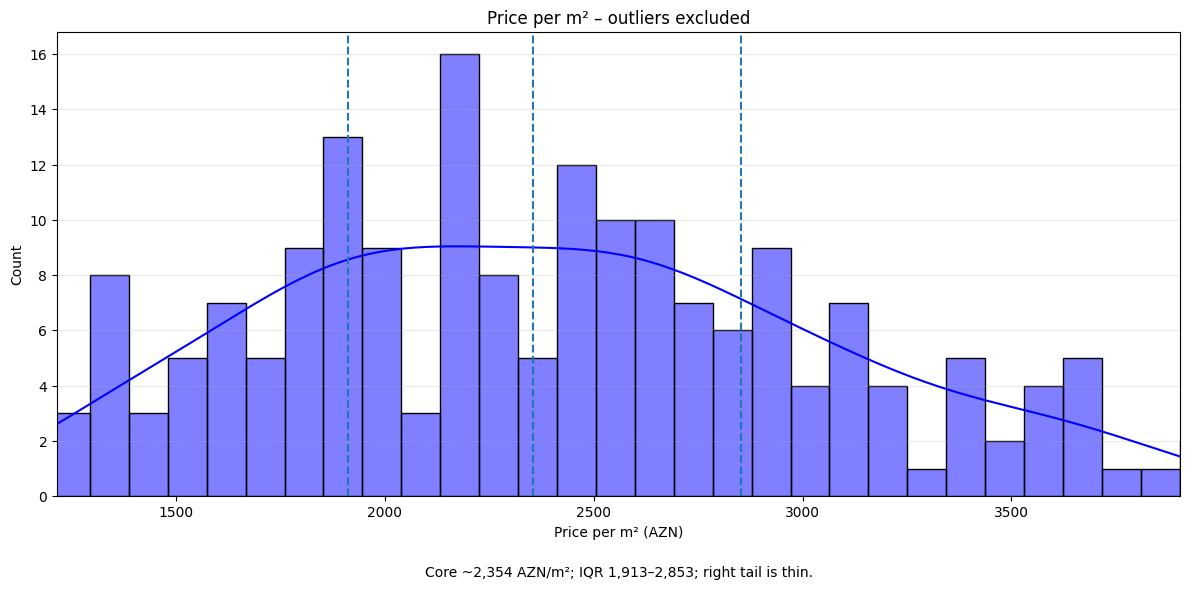

In [12]:
# 3. Exploratory Analysis & Visuals
import matplotlib.pyplot as plt
import seaborn as sns
# •	Histogram – Price per m² distribution.

s = df_clean["Price per m^2"].dropna()
q1, med, q3 = s.quantile([0.25, 0.50, 0.75])
p1, p99 = s.quantile([0.01, 0.99])


plt.figure(figsize=(12,6))
sns.histplot(s, bins=30, kde=True, color="blue")
plt.xlim(p1, p99)
plt.axvline(q1, linestyle="--"); plt.axvline(med, linestyle="--"); plt.axvline(q3, linestyle="--")
plt.xlabel("Price per m² (AZN)"); plt.ylabel("Count"); plt.title("Price per m² – outliers excluded")
plt.grid(True, axis="y", alpha=0.25)
ax = plt.gca()
caption = f"Core ~{int(med):,} AZN/m²; IQR {int(q1):,}–{int(q3):,}; right tail is thin."
ax.text(0.5, -0.15, caption, transform=ax.transAxes, ha="center", va="top")

plt.tight_layout(); 
plt.show()

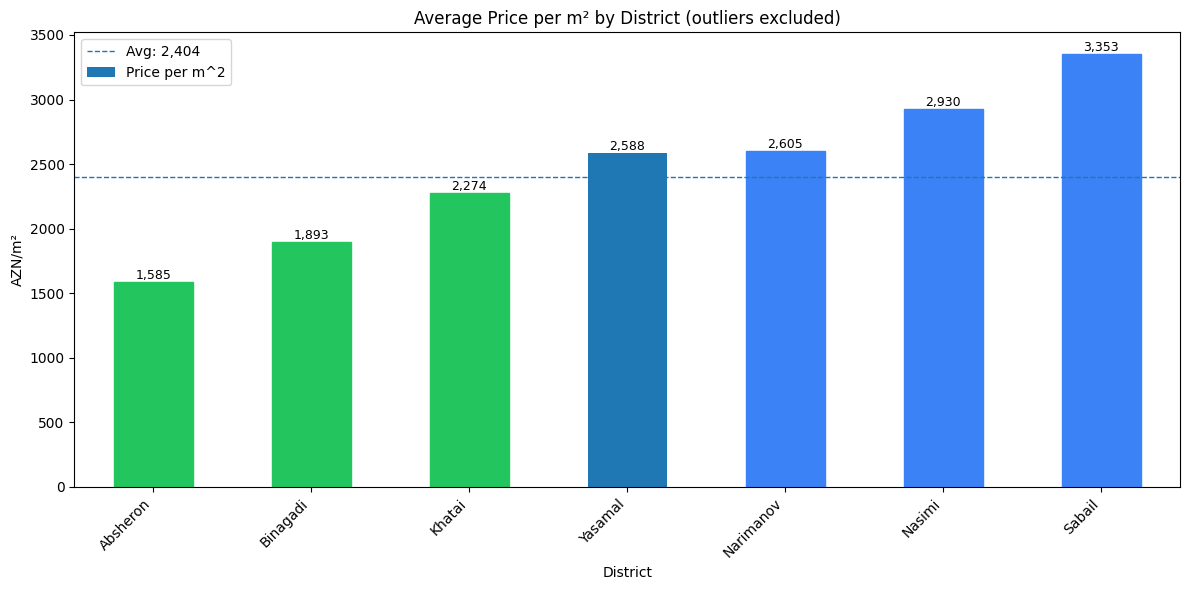

Bottom 3: {'Absheron': 1585.0, 'Binagadi': 1893.0, 'Khatai': 2274.0}
Top 3: {'Sabail': 3353.0, 'Nasimi': 2930.0, 'Narimanov': 2605.0}


In [13]:


# •	Bar chart – Mean Price per m² by District (highlight top 3 expensive and cheap districts).
# Bar chart — district avg Price per m² (df_clean, outliers excluded)


g = df_clean.groupby("District")["Price per m^2"].mean().sort_values()
top3, bot3 = g.tail(3), g.head(3)

ax = g.plot.bar(figsize=(12,6))
ax.set_title("Average Price per m² by District (outliers excluded)")
ax.set_ylabel("AZN/m²"); plt.xticks(rotation=45, ha="right")

# Overall avg (all listings) and highlight
avg_all = df_clean["Price per m^2"].mean()
ax.axhline(avg_all, linestyle="--", linewidth=1, label=f"Avg: {avg_all:,.0f}")
ax.legend()

# Highlight: Top3 blue, Bottom3 green

for i, d in enumerate(g.index):
    if d in top3.index:  ax.patches[i].set_color("#3B82F6")
    if d in bot3.index:  ax.patches[i].set_color("#22C55E")

for p in ax.patches:
    v = p.get_height()
    ax.annotate(f"{v:,.0f}", (p.get_x()+p.get_width()/2, v),
                ha="center", va="bottom", fontsize=9)
ax.margins(y=0.05)  

plt.tight_layout(); plt.show()

print("Bottom 3:", bot3.round(0).to_dict())
print("Top 3:",    top3.round(0).iloc[::-1].to_dict())




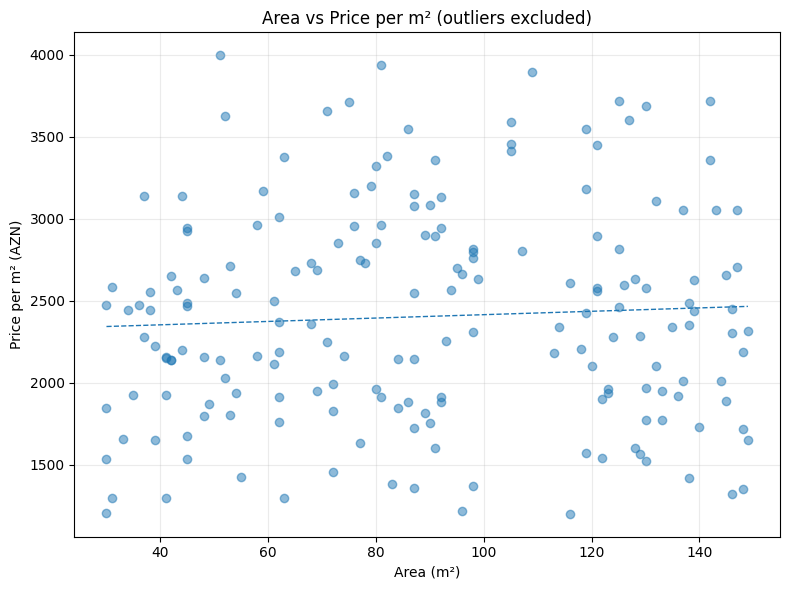

corr(Area, ppm²) = 0.057  |  slope = 1.03 AZN/m² per m²
Comment: No meaningful relationship


In [14]:

# •	Scatterplot – Area vs. Price/m² (“bulk discount” effect?).

df_sc = df_clean.dropna(subset=["Area (in m^2)", "Price per m^2"]).copy()
x = df_sc["Area (in m^2)"].astype(float).values
y = df_sc["Price per m^2"].astype(float).values

# Pearson correlation and linear trend
r = float(np.corrcoef(x, y)[0,1])
m, b = np.polyfit(x, y, 1)  # y = m*x + b

plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.5)
xx = np.linspace(x.min(), x.max(), 200)
plt.plot(xx, m*xx + b, linestyle="--", linewidth=1)  # trend line

plt.xlabel("Area (m²)")
plt.ylabel("Price per m² (AZN)")
plt.title("Area vs Price per m² (outliers excluded)")
plt.grid(True, axis="both", alpha=0.25)
plt.tight_layout(); plt.show()

print(f"corr(Area, ppm²) = {r:.3f}  |  slope = {m:.2f} AZN/m² per m²")
if r < -0.10:
    print("Comment:", "Bulk discount EXISTS (negative relationship)")
elif r > 0.10:
    print("Comment:", "Reverse relationship")
else:
    print("Comment:", "No meaningful relationship")





In [ ]:
# df.info()
# df.describe()

# column order (District is the first column):
cols = ["District", "Area (in m^2)", "Price (in AZN)", "Price per m^2",
        "Rooms", "Floor", "Total floors",
        "Outlier_IQR", "Outlier_Z", "Outlier_EITHER", "Outlier_BOTH"]

# Flagged (outlier flagged, not deleted)
df[cols].to_csv("BCR_Flagged.csv", index=False)

# df_clean.info()
df_clean.describe()

# to csv
cols = ["District", "Area (in m^2)", "Price (in AZN)", "Price per m^2", 
        "Rooms", "Floor", "Total floors"  ]

df_clean[cols].to_csv("BCR_RealEstate_Clean.csv", index=False)
